In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
my_transforms = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            transforms.RandomCrop((124,124)),  # corte a imagem saindo outra com o tamanho informado (222, 222)
            transforms.ColorJitter(brightness=0.5),  # aumenta ou diminui o brilho e a saturação da imagem em 50%
            transforms.RandomRotation(degrees=5),  # gira a imagem em 5º
            transforms.RandomHorizontalFlip(p=0.5),  # espelha a imagem 0|-< vira >-|0 (isso era pra ser uma pessoa deitada)
            transforms.RandomVerticalFlip(p=0.01),  # espelha a imagem verticalmente
            transforms.RandomGrayscale(p=0.2),  # converte a imagem em tons de cinza
            transforms.ToTensor(),
            transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
        ]
    )

In [5]:
root_dir = Path('data/catDog/train')
train_dataset = datasets.ImageFolder(root=root_dir, transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: data\catDog\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(124, 124), padding=None)
               ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.01)
               RandomGrayscale(p=0.2)
               ToTensor()
               Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
           )


In [7]:
print(f'As classes são: {train_dataset.class_to_idx}')

As classes são: {'Cats': 0, 'Dogs': 1}


In [8]:
def visualization_image(dataset, id_: int = 0, axs=None):
    image, label = dataset[id_]
    image = np.transpose(image, (1, 2, 0))
    mean = np.array([0., 0., 0.])
    std = np.array([1., 1., 1.])
    image = std * np.array(image) + mean
    if axs is None:
        fig, ax = plt.subplots()
    else:
        ax = axs
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    return ax

def get_images(id_: int):
    fig, axs = plt.subplots(nrows=2, ncols=4)
    for i in range(2):
        for j in range(4):
            visualization_image(train_dataset, id_=id_, axs=axs[i, j])
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
max_memory = torch.cuda.max_memory_allocated()
print(f'Máximo histórico de memória alocada na GPU: {max_memory / 1024**3:.2f} GB')

Máximo histórico de memória alocada na GPU: 0.00 GB


Imagens de um Cachorro com algumas transformações:


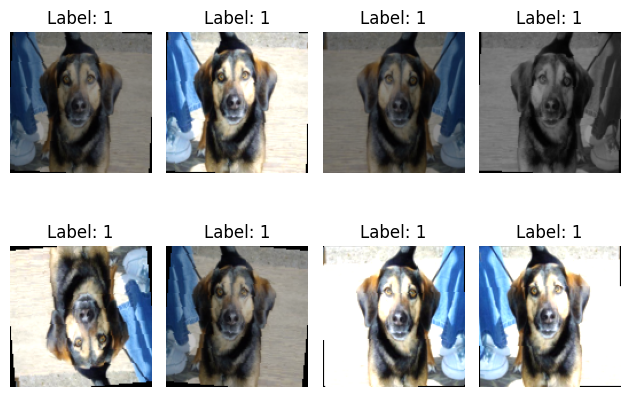

In [10]:
print('Imagens de um Cachorro com algumas transformações:')
get_images(id_=17000)

Imagens de um Gato com algumas transformações:


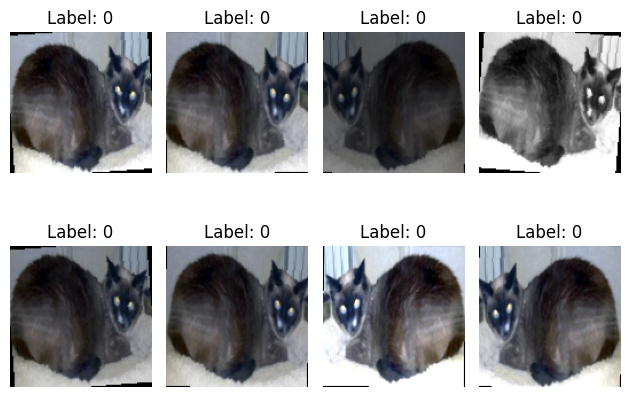

In [11]:
print('Imagens de um Gato com algumas transformações:')
get_images(id_=10)

In [12]:
class CatDogClassifer(nn.Module):
    def __init__(self):
        super(CatDogClassifer, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 124, kernel_size=(3, 3)),
            nn.BatchNorm2d(124),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.01)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(124, 64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.01)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.01)
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(32, 12, kernel_size=(3, 3)),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.01)
        )
        self.flatten = nn.Flatten()
        self.fully_connected = nn.Sequential(
            nn.Linear(12 * 5 * 5, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.flatten(x)
        x = self.fully_connected(x)
        x = self.sigmoid(x)
        return x

In [13]:
model = CatDogClassifer().to(device)

In [14]:
def accuracy(output, target):
    preds = torch.round(output)
    correct = (preds == target).sum().float()
    return correct / len(target)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()

In [16]:
torch.cuda.empty_cache()
max_memory = torch.cuda.max_memory_allocated()
print(f'Máximo histórico de memória alocada na GPU: {max_memory / 1024**3:.2f} GB')

Máximo histórico de memória alocada na GPU: 0.00 GB


In [17]:
metrics = defaultdict(list)

In [19]:
best_acc = 0.0
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    for i, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float()
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # # Calcule a métrica de avaliação
        acc = accuracy(outputs, targets)
        
        # Salve o modelo se o desempenho for melhor
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'models/cat_dog_classifier.pt')
        
        # Atualize o tqdm com as estatísticas
        loop.set_description(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        loop.set_postfix(loss=loss.item(), accuracy=acc.item(), best_accuracy=best_acc.item())

        # adicionando as metricas
        metrics['train_losses'].append(np.mean(loss.item()))
        metrics['train_acc'].append(np.mean(acc.item()))
    
print(f"Training completed! Best accuracy: {best_acc.item():.4f}")

Training completed! Best accuracy: 1.0000


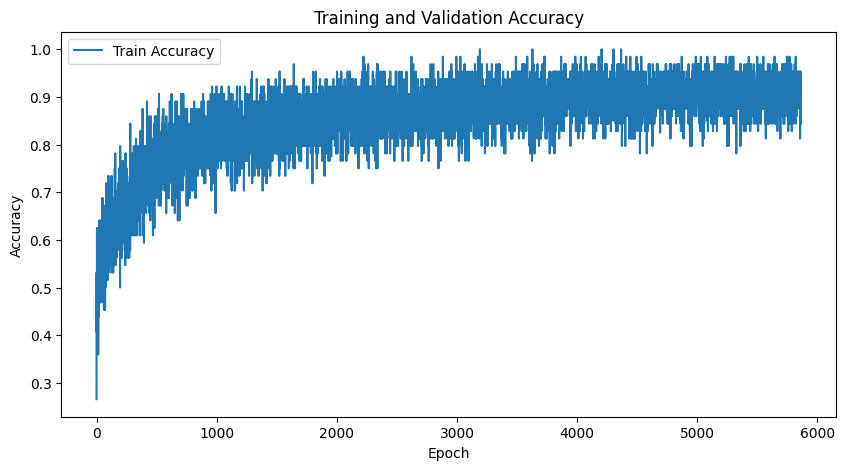

In [22]:
# Plotar gráfico para precisão de treinamento
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

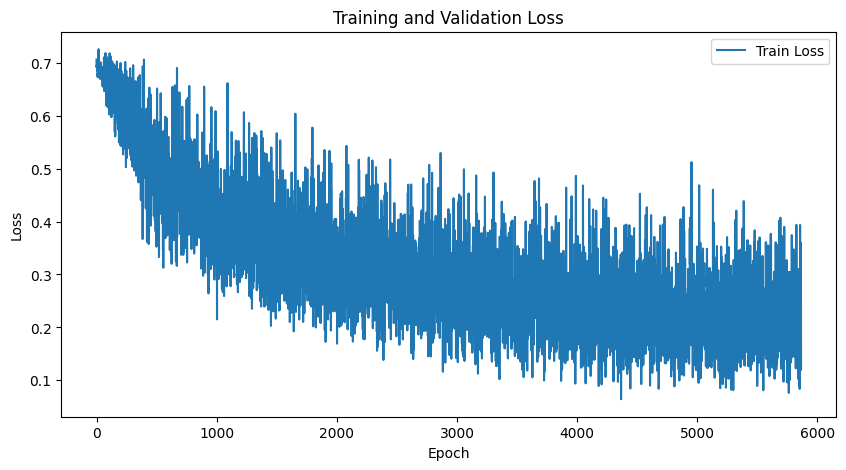

In [21]:
# Plotar gráfico para perdas de treinamento
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_losses'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Preditando para novas amostras

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
test_transforms = transforms.Compose(
        [
            transforms.Resize((124, 124)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
        ]
    )

In [93]:
@torch.no_grad()
def predict(model, input_data):
    model.eval()
    input_data = input_data.unsqueeze(0)
    pred_proba = model(input_data)
    output = torch.round(pred_proba)
    # pred_proba = torch.round(pred_proba, decimals=10)
    output, pred_proba = output.item(), pred_proba.item()
    return {'pred': output, 'pred_proba': round(pred_proba,3)}

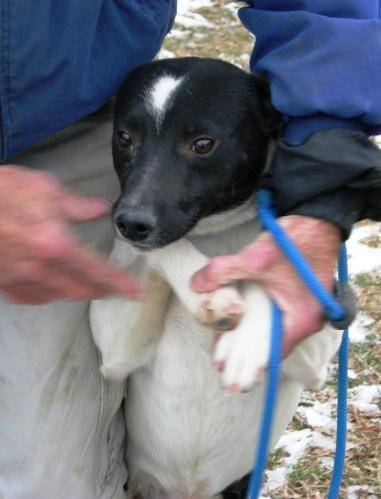

In [94]:
image_path = Path('data/catDog/test/1.jpg')

imagem_pil = Image.open(image_path)

imagem_pil

In [95]:
image_tensor = test_transforms(imagem_pil)
image_tensor = image_tensor.to(device)

In [96]:
predict(model, image_tensor)

{'pred': 1.0, 'pred_proba': 0.967}

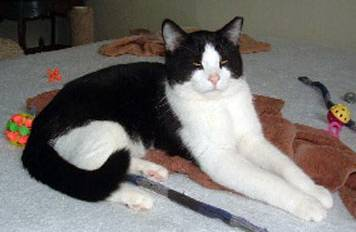

In [97]:
image_path = Path('data/catDog/test/20.jpg')

imagem_pil = Image.open(image_path)

imagem_pil

In [98]:
image_tensor = test_transforms(imagem_pil)
image_tensor = image_tensor.to(device)

In [99]:
predict(model, image_tensor)

{'pred': 0.0, 'pred_proba': 0.0}